In [50]:
import os
import copy
import easydict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader

from torchmeta.utils.data import BatchMetaDataLoader
from maml.utils import load_dataset, load_model, update_parameters, get_accuracy, get_graph_regularizer

import os
import numpy as np
import pandas as pd

# log graph

In [51]:
def plot_logs(log_type, logs, ax):
    if log_type == 'error':
        train_log = np.array(logs['train_error'])
        valid_log = np.array(logs['valid_error'])
        test_log = np.array(logs['test_error'])
        ymin = 0.0
        ymax = 3.0
        ax.set_title('error graph, test error: {}'.format(round(test_log[-1],4)))
    elif log_type == 'accuracy':
        train_log = np.array(logs['train_accuracy'])
        valid_log = np.array(logs['valid_accuracy'])
        test_log = np.array(logs['test_accuracy'])
        ymin = 0.0
        ymax = 1.0
        ax.set_title('accruacy graph, test accruacy: {}'.format(round(test_log[-1],4)))
    
    ax.plot(train_log.nonzero()[0], train_log[train_log.nonzero()[0]], label='train')
    ax.plot(valid_log.nonzero()[0], valid_log[valid_log.nonzero()[0]], label='valid')
    ax.scatter(test_log.nonzero()[0], test_log[test_log.nonzero()[0]], s=100, color='red', label='test')
    
    ax.set_ylim([ymin, ymax])
    ax.legend()

def plot_diff_logs(filename_list):
    fig, axes = plt.subplots(1, 2, sharey=False, figsize=(16,8))
    
    error_logs_list = []
    accuracy_logs_list = []
    
    for filename in filename_list:
        file_logs = pd.read_csv(filename)
        error_logs_list.append(np.array(file_logs['valid_error']))
        accuracy_logs_list.append(np.array(file_logs['valid_accuracy']))
    
    for filename, error_logs in list(zip(filename_list, error_logs_list)):
        axes[0].plot(error_logs.nonzero()[0], error_logs[error_logs.nonzero()[0]], label="_".join(filename.split("/")[2].split("_")[1:]))
    axes[0].set_ylim([0.0, 3.0])
    axes[0].legend()

    for filename, accuracy_logs in list(zip(filename_list, accuracy_logs_list)):
        axes[1].plot(accuracy_logs.nonzero()[0], accuracy_logs[accuracy_logs.nonzero()[0]], label="_".join(filename.split("/")[2].split("_")[1:]))
    axes[1].set_ylim([0.4, 0.7])
    axes[1].legend()
        
    plt.show()
    plt.close()

In [42]:
path = './output/'
file_list = os.listdir(path)
file_list = sorted([f for f in file_list if 'miniimagenet' in f])
print (file_list)

['miniimagenet_adaptive_lr_gr1e-1_outer_sq', 'miniimagenet_adaptive_lr_gr1e-2_outer_ss_sq', 'miniimagenet_adaptive_lr_scale', 'miniimagenet_adaptive_lr_scale_gr1e-2_sq', 'miniimagenet_auto_adaptive_lr_600', 'miniimagenet_auto_adaptive_lr_gr1e-2_sq', 'miniimagenet_auto_adaptive_scale_lr_gr1e-2_sq', 'miniimagenet_da', 'miniimagenet_gr1e-1_outer_sq', 'miniimagenet_gr1e-1_sq_double', 'miniimagenet_gr1e-2_outer_ss_sq', 'miniimagenet_gr1e-2_outer_ss_sq_qq', 'miniimagenet_gr1e-2_sq_double', 'miniimagenet_gr1e-2_sq_double1', 'miniimagenet_gr1e-2_sq_double_min', 'miniimagenet_gr1e-2_sq_qq', 'miniimagenet_maml_stepsize0.5']


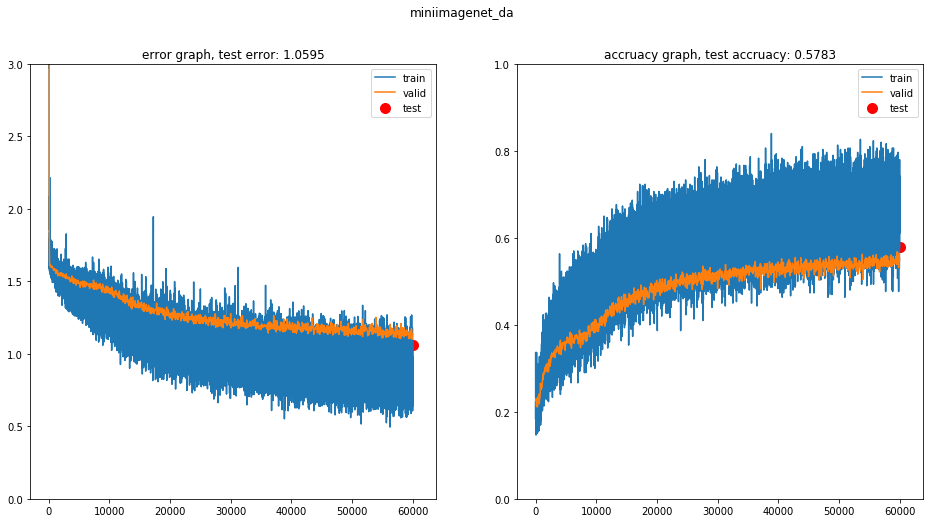

In [52]:
filename = './output/{}/logs/logs.csv'.format(file_list[7])
logs = pd.read_csv(filename)

fig, axes = plt.subplots(1, 2, sharey=False, figsize=(16, 8))

plot_logs(log_type='error', logs=logs, ax=axes[0])
plot_logs(log_type='accuracy', logs=logs, ax=axes[1])

plt.suptitle(filename.split("/")[2])
plt.show()
plt.close()

In [53]:
file1 = [f for f in file_list if 'step_size0.05' in f]
file2 = [f for f in file_list if 'step_size0.5' in f]
file3 = [f for f in file_list if 'step_size5.0' in f]

filename1 = './output/{}/logs/logs.csv'.format(file1[0])
filename2 = './output/{}/logs/logs.csv'.format(file2[0])
filename3 = './output/{}/logs/logs.csv'.format(file3[0])

filename_list = [filename1, filename2, filename3]
plot_diff_logs(filename_list)

IndexError: list index out of range

# Overfitting test
### Overfitting 1: meta train <-> meta test
### Overfitting 2: support <-> query in meta test

In [54]:
args = easydict.EasyDict({'folder': './dataset',
                          'dataset': 'miniimagenet',
                          'device': 'cuda:1',
                          'download': True,
                          'num_shots': 5,
                          'num_ways': 5,
                          'meta_lr': 1e-3,
                          'first_order': False,
                          'step_size': 0.5,
                          'hidden_size': 64,
                              'output_folder': './output/',
                          'save_name': None,
                          'batch_size': 4,
                          'batch_iter': 1200,
                          'train_batches': 50,
                          'valid_batches': 25,
                          'test_batches': 2500,
                          'num_workers': 1,
                          'graph_gamma': 5.0,
                          'graph_beta': 1e-5,
                          'graph_regularizer': False,
                          'fc_regularizer': False,
                          'task_embedding_method': None,
                          'edge_generation_method': None,
                          'best_valid_error_test': False,
                          'best_valid_accuracy_test': False,
                          'adaptive_lr': False,
                          'adaptive_lr_double_inner_loop': False,
                          'double_inner_loop': False})

In [55]:
def make_sample_task(dataset):
    sample_task = dataset.sample_task()
    for idx, (image, label) in enumerate(sample_task['train']): # support set in meta_test
        if idx == 0:
            s_images = image.unsqueeze(0)
            s_labels = [label]
            s_real_labels = [sample_task['train'].index[label]]
        else:
            s_images = torch.cat([s_images, image.unsqueeze(0)], dim=0)
            s_labels.append(label)
            s_real_labels.append(sample_task['train'].index[label])
    
    for idx, (image, label) in enumerate(sample_task['test']): # query set in meta_test
        if idx == 0:
            q_images = image.unsqueeze(0)
            q_labels = [label]
            q_real_labels = [sample_task['test'].index[label]]
        else:
            q_images = torch.cat([q_images, image.unsqueeze(0)], dim=0)
            q_labels.append(label)
            q_real_labels.append(sample_task['test'].index[label])
    
    s_labels = torch.tensor(s_labels).type(torch.LongTensor)
    s_real_labels = torch.tensor(s_real_labels).type(torch.LongTensor)
    q_labels = torch.tensor(q_labels).type(torch.LongTensor)
    q_real_labels = torch.tensor(q_real_labels).type(torch.LongTensor)
    return [s_images, s_labels, s_real_labels, q_images, q_labels, q_real_labels]

In [5]:
def print_accuracy(args, meta_mode):
    sample_number = 1000
    sample_tasks = [make_sample_task(load_dataset(args, meta_mode)) for _ in tqdm(range(sample_number))]

    before_support_accuracy_list = []
    after_support_accuracy_list = []
    after_query_accuracy_list = []

    for idx in tqdm(range(sample_number)):
        model = load_model(args)
        checkpoint = args.output_folder + '{}_{}/'.format(args.dataset, args.save_name) + 'models/epochs_20000.pt'
        checkpoint = torch.load(checkpoint)
        model.load_state_dict(checkpoint, strict=True)

        model.to(args.device)

        support_input = sample_tasks[idx][0].to(args.device)
        support_target = sample_tasks[idx][1].to(args.device)
        support_real_target = sample_tasks[idx][2]
        query_input = sample_tasks[idx][3].to(args.device)
        query_target = sample_tasks[idx][4].to(args.device)
        query_real_target = sample_tasks[idx][5]

        model.train()
        support_features, support_logit = model(support_input, update_mode='inner')
        _, support_pred_target = torch.max(support_logit, dim=1)
        before_support_accuracy_list.append(sum(support_target==support_pred_target)/float(len(support_target)))

        inner_loss = F.cross_entropy(support_logit, support_target)
        model.zero_grad()
        params = update_parameters(model, inner_loss, step_size=args.step_size, first_order=args.first_order)
        support_features, support_logit = model(support_input, update_mode='inner', params=params) # inner loss를 통해 적어도 1번이라도 업데이트 되었을 때 (params=params 들어갔을 떄), 제대로된 task_embedding이 뽑힘. 근데 뽑는다 한들 어떻게 합치지;;
        _, support_pred_target = torch.max(support_logit, dim=1)
        after_support_accuracy_list.append(sum(support_target==support_pred_target)/float(len(support_target)))

        query_features, query_logit = model(query_input, update_mode='inner', params=params)
        _, query_pred_target = torch.max(query_logit, dim=1)
        after_query_accuracy_list.append(sum(query_target==query_pred_target)/float(len(query_target)))

    before_support_accuracy_list = [v.cpu().item() for v in before_support_accuracy_list]
    after_support_accuracy_list = [v.cpu().item() for v in after_support_accuracy_list]
    after_query_accuracy_list = [v.cpu().item() for v in after_query_accuracy_list]

    print (np.mean(before_support_accuracy_list), np.mean(after_support_accuracy_list), np.mean(after_query_accuracy_list))

In [11]:
## args.step_size = 0.05
# args.save_name = 'step_size{}'.format(str(args.step_size))
args.save_name = 'adaptive_lr_inner'
print_accuracy(args, meta_mode='meta_train')
print_accuracy(args, meta_mode='meta_test')

  0%|          | 2/1000 [00:00<00:59, 16.91it/s]

0.20043999442458152 0.9938799967169761 0.7990533526837825


100%|██████████| 1000/1000 [00:47<00:00, 20.85it/s]


0.19631999463587999 0.9910399953126907 0.6276800126135349


In [63]:
def print_accuracy_adaptation_in_test(args, meta_mode, filename, sample_tasks):
    before_support_accuracy_list = []
    after_support_accuracy_list = []
    after_query_accuracy_list = []

    for idx in tqdm(range(sample_number)):
        model, scale_model, lr_model = load_model(args)
        
        logs = pd.read_csv(filename)

        if args.best_valid_error_test:
            valid_logs = list(logs[logs['valid_error']!=0]['valid_error'])
            best_valid_epochs = (valid_logs.index(min(valid_logs))+1)*50
            best_valid_model = torch.load('./output/miniimagenet_{}/models/epochs_{}/model.pt'.format(args.save_name, best_valid_epochs))
            
        elif args.best_valid_accuracy_test:
            valid_logs = list(logs[logs['valid_accuracy']!=0]['valid_accuracy'])
            best_valid_epochs = (valid_logs.index(max(valid_logs))+1)*50
            best_valid_model = torch.load('./output/miniimagenet_{}/models/epochs_{}.pt'.format(args.save_name, best_valid_epochs))
        else:
            checkpoint = args.output_folder + '{}_{}/'.format(args.dataset, args.save_name) + 'models/epochs_20000.pt'
            best_valid_model = torch.load(checkpoint)

        
        model.load_state_dict(best_valid_model)
        model.to(args.device)
        
        support_input = sample_tasks[idx][0].to(args.device)
        support_target = sample_tasks[idx][1].to(args.device)
        support_real_target = sample_tasks[idx][2]
        query_input = sample_tasks[idx][3].to(args.device)
        query_target = sample_tasks[idx][4].to(args.device)
        query_real_target = sample_tasks[idx][5]

        model.train()
        if args.adaptive_lr:
            initial_params=model.state_dict()

        support_features, support_logit = model(support_input)
        if args.adaptive_lr:
            query_features_, query_logit_ = model(query_input)
        _, support_pred_target = torch.max(support_logit, dim=1)
        before_support_accuracy_list.append(sum(support_target==support_pred_target)/float(len(support_target)))

        inner_loss = F.cross_entropy(support_logit, support_target)
        if args.graph_regularizer:
            graph_loss = get_graph_regularizer(features=torch.cat((support_features, query_features_), dim=0), labels=support_target, args=args)
            inner_loss += args.graph_beta * graph_loss
        model.zero_grad()
        params = update_parameters(model, inner_loss, step_size=args.step_size, first_order=args.first_order)
        
        if args.adaptive_lr_double_inner_loop:
            support_features_, support_logit_ = model(support_input, params=params) # get features from task specific parameters
            query_features_, query_logit_ = model(query_input, params=params)
            second_inner_loss = F.cross_entropy(support_logit_, support_target)

            distance = torch.norm(torch.mean(support_features_, dim=0) - torch.mean(query_features_, dim=0))
            adaptive_lr = torch.exp(-0.1 * distance * distance)
            model.zero_grad()
            adaptive_params = update_parameters(model, second_inner_loss, step_size=adaptive_lr, first_order=args.first_order) # not from initial parameter
            params = adaptive_params

        elif args.double_inner_loop:
            support_features_, support_logit_ = model(support_input, params=params)
            second_inner_loss = F.cross_entropy(support_logit_, support_target)
            model.zero_grad()
            second_params = update_parameters(model, second_inner_loss, step_size=args.step_size, first_order=args.first_order)
            params = second_params

        elif args.adaptive_lr:
            distance = torch.norm(torch.mean(support_features, dim=0) - torch.mean(query_features_, dim=0))
            adaptive_lr = torch.exp(-0.1 * distance * distance)
            if args.graph_regularizer:
                graph_loss = get_graph_regularizer(features=torch.cat((support_features, query_features_), dim=0), labels=support_target, args=args)
                inner_loss += args.graph_beta * graph_loss
            model.load_state_dict(initial_params)
            model.zero_grad()
            adaptive_params = update_parameters(model, inner_loss, step_size=adaptive_lr, first_order=args.first_order)
            params = adaptive_params
            
        
        support_features, support_logit = model(support_input, update_mode='inner', params=params) # inner loss를 통해 적어도 1번이라도 업데이트 되었을 때 (params=params 들어갔을 떄), 제대로된 task_embedding이 뽑힘. 근데 뽑는다 한들 어떻게 합치지;;
        _, support_pred_target = torch.max(support_logit, dim=1)
        after_support_accuracy_list.append(sum(support_target==support_pred_target)/float(len(support_target)))

        query_features, query_logit = model(query_input, update_mode='inner', params=params)
        _, query_pred_target = torch.max(query_logit, dim=1)
        after_query_accuracy_list.append(sum(query_target==query_pred_target)/float(len(query_target)))

    before_support_accuracy_list = [v.cpu().item() for v in before_support_accuracy_list]
    after_support_accuracy_list = [v.cpu().item() for v in after_support_accuracy_list]
    after_query_accuracy_list = [v.cpu().item() for v in after_query_accuracy_list]

    print (np.mean(before_support_accuracy_list), np.mean(after_support_accuracy_list), np.mean(after_query_accuracy_list))

In [58]:
sample_number = 1000
train_sample_tasks = [make_sample_task(load_dataset(args, 'meta_train')) for _ in tqdm(range(sample_number))]
test_sample_tasks = [make_sample_task(load_dataset(args, 'meta_test')) for _ in tqdm(range(sample_number))]


100%|██████████| 1000/1000 [00:52<00:00, 18.92it/s]

100%|██████████| 1000/1000 [00:54<00:00, 18.45it/s]


In [59]:
path = './output/'
file_list = os.listdir(path)
file_list = sorted([f for f in file_list if 'miniimagenet' in f])
print (file_list)

['miniimagenet_adaptive_lr_gr1e-1_outer_sq', 'miniimagenet_adaptive_lr_gr1e-2_outer_ss_sq', 'miniimagenet_adaptive_lr_scale', 'miniimagenet_adaptive_lr_scale_gr1e-2_sq', 'miniimagenet_auto_adaptive_lr_600', 'miniimagenet_auto_adaptive_lr_gr1e-2_sq', 'miniimagenet_auto_adaptive_scale_lr_gr1e-2_sq', 'miniimagenet_da', 'miniimagenet_gr1e-1_outer_sq', 'miniimagenet_gr1e-1_sq_double', 'miniimagenet_gr1e-2_outer_ss_sq', 'miniimagenet_gr1e-2_outer_ss_sq_qq', 'miniimagenet_gr1e-2_sq_double', 'miniimagenet_gr1e-2_sq_double1', 'miniimagenet_gr1e-2_sq_double_min', 'miniimagenet_gr1e-2_sq_qq', 'miniimagenet_maml_stepsize0.5']


In [61]:
filename = './output/{}/logs/logs.csv'.format(file_list[7])
print(filename)

./output/miniimagenet_da/logs/logs.csv


In [64]:
args.save_name = 'da'
args.adaptive_lr = False
args.graph_regularizer = False
args.graph_beta=1e-2
args.graph_edge_generation = 'sq'
args.best_valid_error_test = True
args.best_valid_accuracy_test = False
print_accuracy_adaptation_in_test(args, meta_mode='meta_train', filename = filename, sample_tasks=train_sample_tasks)
print_accuracy_adaptation_in_test(args, meta_mode='meta_test', filename = filename, sample_tasks=test_sample_tasks)


100%|██████████| 1000/1000 [01:29<00:00, 11.12it/s][A

  0%|          | 2/1000 [00:00<01:23, 11.92it/s]

0.19999998807907104 0.805919974386692 0.6101200135946274



100%|██████████| 1000/1000 [01:19<00:00, 12.51it/s]

0.19999998807907104 0.7755599765777588 0.5276933451890945


In [ ]:
# args.step_size = 0.05
# args.save_name = 'step_size{}'.format(str(args.step_size))
args.save_name = 'adaptive_lr_inner_new_gr1e-2_outer'
args.adaptive_lr = True
print_accuracy_adaptation_in_test(args, meta_mode='meta_train', train_sample_tasks)
print_accuracy_adaptation_in_test(args, meta_mode='meta_test', test_sample_tasks)

In [ ]:
args.save_name = 'adaptive_lr_inner_new_gr1e-2_outer'
args.adaptive_lr = True
args.graph_regularizer = True
args.graph_beta = 1e-2
print_accuracy_adaptation_in_test(args, meta_mode='meta_train')
print_accuracy_adaptation_in_test(args, meta_mode='meta_test')